# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

## Import basic libraries

In [5]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables import encode_tags

## Data Importing

In [32]:


def flatten_json(json_data, key_prefix="", sep="."):
    """
    Flattens a nested JSON-like dictionary, except for the 'tags' field.
    Args:
        json_data: The JSON data (dictionary) to flatten.
        key_prefix:  A prefix to add to the keys (used for recursion).
        sep: The separator to use between nested keys.
    Returns:
        A flattened dictionary.
    """
    flattened = {}
    for k, v in json_data.items():
        new_key = key_prefix + k if key_prefix else k
        if k == "tags":
            flattened[new_key] = v
        elif isinstance(v, dict):
            flattened.update(flatten_json(v, new_key + sep, sep=sep))
        elif isinstance(v, list):
            for i, item in enumerate(v):
                if isinstance(item, dict):
                    flattened.update(flatten_json(item, new_key + f"[{i}]" + sep, sep=sep))
                else:
                    flattened[new_key + f"[{i}]"] = item
        elif v is None:
            flattened[new_key] = None
        else:
            flattened[new_key] = v
    return flattened

def extract_data_from_json_files(directory):
    """
    Extracts data from JSON files in the specified directory and combines them into a single DataFrame.
    
    Args:
        directory: The directory containing the JSON files.
        
    Returns:
        A Pandas DataFrame containing the combined data from all JSON files.
    """
    all_data = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                # Extract the 'results' list from the JSON data
                results = data.get("data", {}).get("results", [])
                # Flatten each result and store in a list
                flattened_data = [flatten_json(result) for result in results]
                all_data.extend(flattened_data)
            except (FileNotFoundError, json.JSONDecodeError) as e:
                print(f"Error processing file {file_path}: {e}")
    
    # Create the Pandas DataFrame
    combined_df = pd.DataFrame(all_data)
    
    return combined_df

# Directory containing the JSON files
directory = "/Users/fitsumbahlebi/Desktop/repo2/LHL-supervised-learning-midterm/data"

# Extract data and create the combined DataFrame
combined_df = extract_data_from_json_files(directory)

# Display the combined DataFrame
print(combined_df.head())

                                  primary_photo.href      last_update_date  \
0  https://ap.rdcpix.com/8c0b391ae4f9bbca36c41d55...  2024-01-17T00:01:55Z   
1  https://ap.rdcpix.com/40c55dc5d4e29ab361ae973e...  2024-01-16T16:49:36Z   
2  https://ap.rdcpix.com/497a833c1c423b26b4f0e5bc...  2024-01-13T00:03:39Z   
3  https://ap.rdcpix.com/ade15664a2e83986c126a23d...  2024-01-16T07:48:30Z   
4  https://ap.rdcpix.com/a5dada323a7e617f2dcc4850...  2024-01-13T00:01:45Z   

  source.plan_id source.agents[0].office_name source.agents[1].office_name  \
0           None                         None                         None   
1           None                         None                         None   
2           None                         None                         None   
3           None                         None                         None   
4           None                         None                         None   

  source.spec_id source.type  \
0           None         mls  

## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

### Drop irrelevant columns

In [133]:
columns_to_drop = [
    # Photo-related columns
    'primary_photo.href', 'photos[0].tags', 'photos[0].href',
    'photos[1].tags', 'photos[1].href', 'photos[2].tags', 
    'photos[2].href', 'photos[3].tags', 'photos[3].href',
    'photos[4].tags', 'photos[4].href', 'primary_photo', 'photos',

    # Office and agent related columns
    'source.agents[0].office_name', 'source.agents[1].office_name',
    'source.agents[2].office_name', 'source.agents[3].office_name',
    'community.advertisers[0].office.hours',
    'community.advertisers[0].office.phones[0].number',
    'community.advertisers[0].office.phones[0].type',
    'community.description.name',
    
    # Virtual tour related columns
    'virtual_tours[0].href', 'virtual_tours[0].type', 'virtual_tours',
    
    # Other listings related columns
    'other_listings.rdc[0].listing_id', 'other_listings.rdc[0].status', 
    'other_listings.rdc[4].listing_id', 'other_listings.rdc[4].status',
    'other_listings.rdc[5].listing_id', 'other_listings.rdc[5].status',
    'other_listings.rdc[6].listing_id', 'other_listings.rdc[6].status',
    'other_listings.rdc[7].listing_id', 'other_listings.rdc[7].status',
    'other_listings.rdc[8].listing_id', 'other_listings.rdc[8].status',
    'other_listings.rdc[9].listing_id', 'other_listings.rdc[9].status',
    'other_listings.rdc[10].listing_id', 'other_listings.rdc[10].status',
    'other_listings.rdc[11].listing_id', 'other_listings.rdc[11].status',
    'other_listings.rdc[12].listing_id', 'other_listings.rdc[12].status',
    'other_listings.rdc[13].listing_id', 'other_listings.rdc[13].status',
    'other_listings.rdc[14].listing_id', 'other_listings.rdc[14].status',
    'other_listings.rdc[15].listing_id', 'other_listings.rdc[15].status',
    'other_listings', 'other_listings.rdc[0].primary', 'other_listings.rdc[1].primary',
    'other_listings.rdc[1].listing_id', 'other_listings.rdc[1].status', 
    'other_listings.rdc[2].listing_id', 'other_listings.rdc[2].status', 
    'other_listings.rdc[3].listing_id', 'other_listings.rdc[3].status', 
    'other_listings.rdc[3].primary', 'other_listings.rdc[2].primary',
    'other_listings.rdc[2].listing_key',
    'other_listings.rdc[3].listing_key', 'branding[0].photo',
    'other_listings.rdc[4].listing_key', 'other_listings.rdc[4].primary',
    'other_listings.rdc[5].listing_key', 'other_listings.rdc[5].primary',
    'other_listings.rdc[6].listing_key', 'other_listings.rdc[6].primary',
    'other_listings.rdc[7].listing_key', 'other_listings.rdc[7].primary',
    'other_listings.rdc[8].listing_key', 'other_listings.rdc[8].primary',
    'other_listings.rdc[9].listing_key', 'other_listings.rdc[9].primary',
    'other_listings.rdc[10].listing_key', 'other_listings.rdc[10].primary',
    'other_listings.rdc[11].listing_key', 'other_listings.rdc[11].primary',
    'other_listings.rdc[12].listing_key', 'other_listings.rdc[12].primary',
    'other_listings.rdc[13].listing_key', 'other_listings.rdc[13].primary',
    'other_listings.rdc[14].listing_key', 'other_listings.rdc[14].primary',
    'other_listings.rdc[15].listing_key', 'other_listings.rdc[15].primary',
    'other_listings.rdc[0].listing_key', 'other_listings.rdc[1].listing_key',

    # Source and metadata related columns
    'source.plan_id', 'source.spec_id', 'source', 'products',
    'last_update_date', 'lead_attributes.show_contact_an_agent',
    'location.county.fips_code', 'location.address.coordinate',
    'flags.is_foreclosure',
    
    # Empty Columns
    'baths_1qtr', 'location.county', 'property_name', 'is_subdivision',
    'is_for_rent', 'is_new_construction', 'is_pending', 'is_plan',
    'is_coming_soon', 'community', 'baths_1qtr', 'is_contingent',
    'open_houses', 'description.name', 'branding[0].name', 'description.baths_1qtr',
    'branding[0].type', 'flags.is_new_construction', 'flags.is_for_rent',
    'flags.is_subdivision', 'flags.is_contingent', 'flags.is_pending', 'flags.is_plan',
    'flags.is_coming_soon', 'listing_id', 'location.street_view_url'
]
# Drop the specified columns from the DataFrame
combined_after_drop_df = combined_df.drop(columns=columns_to_drop, axis=1,errors='ignore')

### Checking for unique Values

In [134]:
# Check unique values for each column in non_zero_cols

for col in combined_after_drop_df.columns:
    print(f"\nColumn: {col}")
    try:
        # Handle list-type columns differently
        if col == 'property_tags':
            # Get all unique tags across all lists
            all_tags = set()
            for tags in combined_df[col].dropna():
                if isinstance(tags, list):
                    all_tags.update(tags)
            print("Unique tags found:", len(all_tags))
            print("Sample of tags:", list(all_tags)[:5])
        else:
            unique_values = combined_df[col].unique()
            print(f"Count of unique values: {len(unique_values)}")
            print("Sample values:", unique_values[:5])
    except Exception as e:
        print(f"Could not process column due to: {str(e)}")
        
    if col != 'property_tags':  # Skip checking tags
        try:
            unique_values = combined_df[col].unique()
            print(f"Count of unique values: {len(unique_values)}")
            print("Sample values:", unique_values[:5])
        except Exception as e:
            print(f"Could not process column due to: {str(e)}")
    print("-" * 50)


Column: source.type
Count of unique values: 2
Sample values: ['mls' nan]
Count of unique values: 2
Sample values: ['mls' nan]
--------------------------------------------------

Column: tags
Could not process column due to: unhashable type: 'list'
Could not process column due to: unhashable type: 'list'
--------------------------------------------------

Column: permalink
Count of unique values: 1795
Sample values: ['1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879'
 '3100-N-3rd-St_Harrisburg_PA_17110_M31492-47078'
 '7551-Davids-Rd_Harrisburg_PA_17111_M46860-76173'
 '2722-Bur-Ct_Harrisburg_PA_17112_M40850-14275'
 '404-Crescent-St_Harrisburg_PA_17104_M37433-85520']
Count of unique values: 1795
Sample values: ['1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879'
 '3100-N-3rd-St_Harrisburg_PA_17110_M31492-47078'
 '7551-Davids-Rd_Harrisburg_PA_17111_M46860-76173'
 '2722-Bur-Ct_Harrisburg_PA_17112_M40850-14275'
 '404-Crescent-St_Harrisburg_PA_17104_M37433-85520']
------------------------------

In [126]:
combined_after_drop_df['description.name'] .value_counts()

Series([], Name: count, dtype: int64)

In [135]:
display(combined_after_drop_df.shape)
display("====================================")
# Display the updated DataFrame
display(combined_after_drop_df.head())
display("====================================")
display(combined_after_drop_df.columns)
display("====================================")
display (combined_after_drop_df.info())

(8159, 34)

'===================================='

,source.type,tags,permalink,status,list_date,description.year_built,description.baths_3qtr,description.sold_date,description.sold_price,description.baths_full,...,price_reduced_amount,location.address.postal_code,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.county.name,matterport
0,mls,"[central_air, dishwasher, fireplace, forced_ai...",1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879,sold,2023-11-27T05:15:07.000000Z,2001.0,NaN,2024-01-16,345000.0,2.0,...,NaN,17110,Pennsylvania,-76.865096,40.316612,Harrisburg,PA,1869 Pebble Ct,Dauphin,False
1,mls,"[disability_features, basement, garage_1_or_mo...",3100-N-3rd-St_Harrisburg_PA_17110_M31492-47078,sold,2023-11-23T11:38:45.000000Z,1900.0,NaN,2024-01-16,196000.0,NaN,...,NaN,17110,Pennsylvania,-76.900123,40.296987,Harrisburg,PA,3100 N 3rd St,Dauphin,False
2,mls,"[carport, central_air, dishwasher, fireplace, ...",7551-Davids-Rd_Harrisburg_PA_17111_M46860-76173,sold,2023-12-16T02:39:18.000000Z,1971.0,NaN,2024-01-12,205000.0,2.0,...,NaN,17111,Pennsylvania,-76.757031,40.257449,Harrisburg,PA,7551 Davids Rd,Dauphin,False
3,mls,"[central_air, dining_room, disability_features...",2722-Bur-Ct_Harrisburg_PA_17112_M40850-14275,sold,2023-10-24T14:15:02.000000Z,2013.0,NaN,2024-01-12,295000.0,2.0,...,NaN,17112,Pennsylvania,-76.821034,40.350224,Harrisburg,PA,2722 Bur Ct,Dauphin,False
4,mls,"[dining_room, hardwood_floors, basement]",404-Crescent-St_Harrisburg_PA_17104_M37433-85520,sold,2023-11-15T17:43:35.000000Z,1900.0,NaN,2024-01-12,106000.0,NaN,...,NaN,17104,Pennsylvania,-76.869911,40.259374,Harrisburg,PA,404 Crescent St,Dauphin,False


'===================================='

Index(['source.type', 'tags', 'permalink', 'status', 'list_date',
       'description.year_built', 'description.baths_3qtr',
       'description.sold_date', 'description.sold_price',
       'description.baths_full', 'description.baths_half',
       'description.lot_sqft', 'description.sqft', 'description.baths',
       'description.sub_type', 'description.garage', 'description.stories',
       'description.beds', 'description.type', 'list_price', 'property_id',
       'flags.is_price_reduced', 'flags.is_new_listing', 'products.brand_name',
       'price_reduced_amount', 'location.address.postal_code',
       'location.address.state', 'location.address.coordinate.lon',
       'location.address.coordinate.lat', 'location.address.city',
       'location.address.state_code', 'location.address.line',
       'location.county.name', 'matterport'],
      dtype='object')

'===================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source.type                      7752 non-null   object 
 1   tags                             7638 non-null   object 
 2   permalink                        8159 non-null   object 
 3   status                           8159 non-null   object 
 4   list_date                        7752 non-null   object 
 5   description.year_built           7316 non-null   float64
 6   description.baths_3qtr           566 non-null    float64
 7   description.sold_date            8159 non-null   object 
 8   description.sold_price           6716 non-null   float64
 9   description.baths_full           7311 non-null   float64
 10  description.baths_half           2281 non-null   float64
 11  description.lot_sqft             6991 non-null   float64
 12  description.sqft    

None

In [136]:
# Get columns with less than 500 nulls and their null counts
null_counts = combined_after_drop_df.isnull().sum()
columns_with_less_than_500_nulls = null_counts[null_counts > 500]
display(columns_with_less_than_500_nulls.sort_values(ascending=False))




description.baths_3qtr    7593
description.sub_type      6732
description.baths_half    5878
flags.is_price_reduced    5675
price_reduced_amount      5675
description.garage        3711
description.stories       1899
description.sold_price    1443
description.lot_sqft      1168
description.baths_full     848
description.year_built     843
description.sqft           836
description.beds           655
tags                       521
dtype: int64

### Renaming the Columns

In [138]:

new_column_names = {
    'source.type': 'listing_source',
    'tags': 'property_tags',
    'permalink': 'full_address',
    'status': 'listing_status',
    'list_date': 'list_date',
    'description.year_built': 'year_built',
    'description.baths_3qtr': 'baths_3qtr',
    'description.sold_date': 'sold_date',
    'description.sold_price': 'sold_price',
    'description.baths_full': 'baths_full',
    'description.name' : 'property_name',
    'description.baths_half': 'baths_half',
    'description.lot_sqft': 'lot_sqft',
    'description.sqft': 'sqft',
    'description.baths': 'baths_total',
    'description.sub_type': 'property_subtype',
    'description.baths_1qtr': 'baths_1qtr',
    'description.garage': 'garage_spaces',
    'description.stories': 'num_stories',
    'description.beds': 'beds',
    'description.type': 'property_type',
    'branding[0].name': 'listing_company_name',
    'branding[0].type': 'listing_company_type',
    'list_price': 'list_price',
    'property_id': 'property_id',
    'flags.is_new_construction' : 'is_new_construction',
    'flags.is_for_rent' : 'is_for_rent', 
    'flags.is_subdivision': 'is_subdivision',
    'flags.is_contingent': 'is_contingent', 
    'flags.is_pending' : 'is_pending', 
    'flags.is_plan' : 'is_plan',
    'flags.is_coming_soon' : 'is_coming_soon',
    'flags.is_price_reduced': 'is_price_reduced',
    'flags.is_new_listing': 'is_new_listing',
    'products.brand_name': 'product_brand',
    'listing_id': 'listing_id',
    'price_reduced_amount': 'price_reduction',
    'location.address.postal_code': 'postal_code',
    'location.address.state': 'state',
    'location.address.coordinate.lon': 'longitude',
    'location.address.coordinate.lat': 'latitude',
    'location.address.city': 'city',
    'location.address.state_code': 'state_code',
    'location.address.line': 'address',
    'location.street_view_url': 'street_view_url',
    'location.county.name': 'county',
    'matterport': 'has_matterport'
}

combined_df_renamed= combined_after_drop_df.rename(columns=new_column_names)

print(combined_df_renamed.columns)  # Verify the column names have changed
print("====================================")
combined_df_renamed.head()  # Display the first few rows of the DataFrame

Index(['listing_source', 'property_tags', 'full_address', 'listing_status',
       'list_date', 'year_built', 'baths_3qtr', 'sold_date', 'sold_price',
       'baths_full', 'baths_half', 'lot_sqft', 'sqft', 'baths_total',
       'property_subtype', 'garage_spaces', 'num_stories', 'beds',
       'property_type', 'list_price', 'property_id', 'is_price_reduced',
       'is_new_listing', 'product_brand', 'price_reduction', 'postal_code',
       'state', 'longitude', 'latitude', 'city', 'state_code', 'address',
       'county', 'has_matterport'],
      dtype='object')


,listing_source,property_tags,full_address,listing_status,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,...,price_reduction,postal_code,state,longitude,latitude,city,state_code,address,county,has_matterport
0,mls,"[central_air, dishwasher, fireplace, forced_ai...",1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879,sold,2023-11-27T05:15:07.000000Z,2001.0,NaN,2024-01-16,345000.0,2.0,...,NaN,17110,Pennsylvania,-76.865096,40.316612,Harrisburg,PA,1869 Pebble Ct,Dauphin,False
1,mls,"[disability_features, basement, garage_1_or_mo...",3100-N-3rd-St_Harrisburg_PA_17110_M31492-47078,sold,2023-11-23T11:38:45.000000Z,1900.0,NaN,2024-01-16,196000.0,NaN,...,NaN,17110,Pennsylvania,-76.900123,40.296987,Harrisburg,PA,3100 N 3rd St,Dauphin,False
2,mls,"[carport, central_air, dishwasher, fireplace, ...",7551-Davids-Rd_Harrisburg_PA_17111_M46860-76173,sold,2023-12-16T02:39:18.000000Z,1971.0,NaN,2024-01-12,205000.0,2.0,...,NaN,17111,Pennsylvania,-76.757031,40.257449,Harrisburg,PA,7551 Davids Rd,Dauphin,False
3,mls,"[central_air, dining_room, disability_features...",2722-Bur-Ct_Harrisburg_PA_17112_M40850-14275,sold,2023-10-24T14:15:02.000000Z,2013.0,NaN,2024-01-12,295000.0,2.0,...,NaN,17112,Pennsylvania,-76.821034,40.350224,Harrisburg,PA,2722 Bur Ct,Dauphin,False
4,mls,"[dining_room, hardwood_floors, basement]",404-Crescent-St_Harrisburg_PA_17104_M37433-85520,sold,2023-11-15T17:43:35.000000Z,1900.0,NaN,2024-01-12,106000.0,NaN,...,NaN,17104,Pennsylvania,-76.869911,40.259374,Harrisburg,PA,404 Crescent St,Dauphin,False


### Data type conversion

In [141]:
from pandas import Int64Dtype

# Assuming your DataFrame is named 'combined_df_renamed'
def booleanConverter(column):
    combined_df_renamed[column] = combined_df_renamed[column].map({'True':True, 'False':False})
    return column
# Convert to datetime
combined_df_renamed['list_date'] = pd.to_datetime(combined_df_renamed['list_date'], errors='coerce')  # 'coerce' will turn invalid dates into NaT
combined_df_renamed['sold_date'] = pd.to_datetime(combined_df_renamed['sold_date'], errors='coerce')

# Integer columns (using Int64 to handle missing values)
numerical_features = ['year_built', 'baths_3qtr', 'baths_full', 'baths_half','baths_total' , 'sold_price', 'price_reduction','garage_spaces', 'num_stories', 'beds']
for col in numerical_features:
    combined_df_renamed[col] = combined_df_renamed[col].astype(Int64Dtype())

#Boolean Converter function
bool_like = ['is_price_reduced', 'is_new_listing', 'has_matterport']
for column in bool_like:
    combined_df_renamed[column] = np.where(combined_df_renamed[column].isin(['True', 'False']), combined_df_renamed[column].map({'True': True, 'False': False}), combined_df_renamed[column])
    combined_df_renamed[column] = combined_df_renamed[column].fillna(False)

# Convert to category
category_cols = ['listing_source', 'property_subtype', 'property_type', 'city', 'state', 'state_code', 'county', 'listing_status']
for col in category_cols:
    combined_df_renamed[col] = combined_df_renamed[col].astype('category')
# Print dtypes to verify
print(combined_df_renamed.dtypes)
print("====================================")
display(combined_df_renamed.head())

listing_source                 category
property_tags                    object
full_address                     object
listing_status                 category
list_date           datetime64[ns, UTC]
year_built                        Int64
baths_3qtr                        Int64
sold_date                datetime64[ns]
sold_price                        Int64
baths_full                        Int64
baths_half                        Int64
lot_sqft                        float64
sqft                            float64
baths_total                       Int64
property_subtype               category
garage_spaces                     Int64
num_stories                       Int64
beds                              Int64
property_type                  category
list_price                      float64
property_id                      object
is_price_reduced                   bool
is_new_listing                     bool
product_brand                    object
price_reduction                   Int64


,listing_source,property_tags,full_address,listing_status,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,...,price_reduction,postal_code,state,longitude,latitude,city,state_code,address,county,has_matterport
0,mls,"[central_air, dishwasher, fireplace, forced_ai...",1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879,sold,2023-11-27 05:15:07+00:00,2001,<NA>,2024-01-16,345000,2,...,<NA>,17110,Pennsylvania,-76.865096,40.316612,Harrisburg,PA,1869 Pebble Ct,Dauphin,False
1,mls,"[disability_features, basement, garage_1_or_mo...",3100-N-3rd-St_Harrisburg_PA_17110_M31492-47078,sold,2023-11-23 11:38:45+00:00,1900,<NA>,2024-01-16,196000,<NA>,...,<NA>,17110,Pennsylvania,-76.900123,40.296987,Harrisburg,PA,3100 N 3rd St,Dauphin,False
2,mls,"[carport, central_air, dishwasher, fireplace, ...",7551-Davids-Rd_Harrisburg_PA_17111_M46860-76173,sold,2023-12-16 02:39:18+00:00,1971,<NA>,2024-01-12,205000,2,...,<NA>,17111,Pennsylvania,-76.757031,40.257449,Harrisburg,PA,7551 Davids Rd,Dauphin,False
3,mls,"[central_air, dining_room, disability_features...",2722-Bur-Ct_Harrisburg_PA_17112_M40850-14275,sold,2023-10-24 14:15:02+00:00,2013,<NA>,2024-01-12,295000,2,...,<NA>,17112,Pennsylvania,-76.821034,40.350224,Harrisburg,PA,2722 Bur Ct,Dauphin,False
4,mls,"[dining_room, hardwood_floors, basement]",404-Crescent-St_Harrisburg_PA_17104_M37433-85520,sold,2023-11-15 17:43:35+00:00,1900,<NA>,2024-01-12,106000,<NA>,...,<NA>,17104,Pennsylvania,-76.869911,40.259374,Harrisburg,PA,404 Crescent St,Dauphin,False


In [172]:
# load and concatenate data here
# drop or replace values as necessary


### Dealing with Null values


---

### Summary: Handling Null Values

We systematically addressed missing values in the dataset by:

---

### Understanding Missingness:

- **MCAR (Missing Completely at Random)**: Data missing without any pattern.
- **MAR (Missing at Random)**: Data missing with a pattern related to observed data.
- **MNAR (Missing Not at Random)**: Data missing with a pattern related to unobserved data.

Evaluated the potential impact of missing values on the final house price prediction model.

---

### Prioritizing Imputation:

Focused on imputing missing values in key features like `year_built`, `sqft`, `baths_full`, `beds`, `longitude`, and `latitude`.



---

### Applying Targeted Imputation Techniques:

- **Mode Imputation**: Used for categorical features like `listing_source`, `property_type`, `listing_company_name`, `city`, and `county`.
- **Median Imputation**: Used for numerical features like `year_built`, `baths_full`, `baths_total`, `lot_sqft`, `sqft`, and `beds`.
- **Zero Filling**: Filled missing values in `baths_3qtr`, `baths_half` and `garage_spaces` with 0, assuming missing values indicate the absence of these features.
- **Conditional Imputation**: Used a conditional approach for `price_reduction`, filling with 0 if `is_price_reduced` is False, otherwise using the median.
- **Geographic Imputation**: Imputed missing `longitude`, `latitude`, `city`, and `county` values based on the `postal_code`. If they were still missing, used global median.
- **Fully Dropping**: Dropped missing subsets of `sold_price`.


---

### Validation:

Checked the number of remaining null values after imputation using `df.isnull().sum()` to ensure complete handling.

---

These steps aim to minimize the impact of missing values on the final model's accuracy and reliability, while considering the specific characteristics and importance of each feature.

In [143]:


# Drop 'list_price' inorder to predict the price of houses not yet listed, too close to the sale price
combined_df_renamed = combined_df_renamed.drop(columns=['list_price'], errors='ignore')

# Convert datetime columns before handling other numeric columns
combined_df_renamed['list_date'] = pd.to_datetime(combined_df_renamed['list_date'], errors='coerce')
combined_df_renamed['sold_date'] = pd.to_datetime(combined_df_renamed['sold_date'], errors='coerce')

# Drop rows with missing 'sold_price' values
combined_df_renamed = combined_df_renamed.dropna(subset=['sold_price'])
# Impute listing_source with mode
combined_df_renamed['listing_source'].fillna(combined_df_renamed['listing_source'].mode()[0], inplace=True)

#Impute longitude and lattitude
combined_df_renamed['latitude'] = combined_df_renamed['latitude'].fillna(combined_df_renamed.groupby('postal_code')['latitude'].transform('median'))
combined_df_renamed['longitude'] = combined_df_renamed['longitude'].fillna(combined_df_renamed.groupby('postal_code')['longitude'].transform('median'))

# Impute year_built with median
combined_df_renamed['year_built'].fillna(combined_df_renamed['year_built'].median(), inplace=True)

# Impute baths_3qtr and baths_half with 0
combined_df_renamed['baths_3qtr'].fillna(0, inplace=True)
combined_df_renamed['baths_half'].fillna(0, inplace=True)
# Impute missing values in 'garage_spaces' with the 0
combined_df_renamed['garage_spaces'].fillna(0, inplace=True)

#Impute with most frequent values.
combined_df_renamed["product_brand"].fillna(combined_df_renamed["product_brand"].mode()[0], inplace = True)
# Impute baths_full and baths_total with median
combined_df_renamed['baths_full'].fillna(combined_df_renamed['baths_full'].median(), inplace=True)
combined_df_renamed['baths_total'].fillna(combined_df_renamed['baths_total'].median(), inplace=True)

# Impute lot_sqft and sqft with median
combined_df_renamed['lot_sqft'].fillna(combined_df_renamed['lot_sqft'].median(), inplace=True)
combined_df_renamed['sqft'].fillna(combined_df_renamed['sqft'].median(), inplace=True)

# Impute property_subtype with mode
combined_df_renamed['property_subtype'].fillna(combined_df_renamed['property_subtype'].mode()[0], inplace=True)

# Impute garage_spaces with 0
combined_df_renamed['garage_spaces'].fillna(0, inplace=True)

# Impute num_stories with mode
combined_df_renamed['num_stories'].fillna(combined_df_renamed['num_stories'].mode()[0], inplace=True)

# Impute beds with median
combined_df_renamed['beds'].fillna(combined_df_renamed['beds'].median(), inplace=True)

# Impute property_type with mode
combined_df_renamed['property_type'].fillna(combined_df_renamed['property_type'].mode()[0], inplace=True)

# For each postal code impute the date with the median sold_date for properties in that postal code
combined_df_renamed['list_date'] = combined_df_renamed['list_date'].fillna(
    combined_df_renamed.groupby('postal_code')['sold_date'].transform(lambda x: x.median() if not x.empty else pd.NaT)
)

# Fill any remaining NaT values with the overall median
if combined_df_renamed['list_date'].isna().any():
    combined_df_renamed['list_date'] = combined_df_renamed['list_date'].fillna(combined_df_renamed['list_date'].median())

# Impute price_reduction (conditional)
combined_df_renamed['price_reduction'] = np.where(combined_df_renamed['is_price_reduced'], combined_df_renamed['price_reduction'].fillna(combined_df_renamed['price_reduction'].median()), 0)

#Handle the updated list_date, listing_id, address and county
# Impute list_date
# For each postal code impute the date with the median sold_date for properties in that postal code
combined_df_renamed['list_date'] = combined_df_renamed['list_date'].fillna(combined_df_renamed.groupby('postal_code')['sold_date'].transform('median'))

#Impute address
# Use a lambda function to handle cases where there's no mode
combined_df_renamed['address'] = combined_df_renamed['address'].fillna(
    combined_df_renamed.groupby('county')['address'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

#Impute County
# Use a lambda function to handle cases where there's no mode
combined_df_renamed['county'] = combined_df_renamed['county'].fillna(
    combined_df_renamed.groupby('postal_code')['county'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

#Impute City
# Use a lambda function to handle cases where there's no mode
combined_df_renamed['city'] = combined_df_renamed['city'].fillna(
    combined_df_renamed.groupby('postal_code')['city'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)
# Attempt to impute remaining latitude/longitude with overall median
combined_df_renamed['latitude'].fillna(combined_df_renamed['latitude'].median(), inplace=True)
combined_df_renamed['longitude'].fillna(combined_df_renamed['longitude'].median(), inplace=True)

print(combined_df_renamed.isnull().sum().sort_values(ascending=False))  # Verify that null values have been handled


property_tags       386
postal_code           0
property_type         0
property_id           0
is_price_reduced      0
is_new_listing        0
product_brand         0
price_reduction       0
listing_source        0
beds                  0
longitude             0
latitude              0
city                  0
state_code            0
address               0
county                0
state                 0
num_stories           0
garage_spaces         0
property_subtype      0
baths_total           0
sqft                  0
lot_sqft              0
baths_half            0
baths_full            0
sold_price            0
sold_date             0
baths_3qtr            0
year_built            0
list_date             0
listing_status        0
full_address          0
has_matterport        0
dtype: int64


### Validation: Check for Lists or dicts in the cols

In [144]:
import pandas as pd

def check_columns_with_lists_or_dicts(df):
    """
    Checks whether columns in the DataFrame contain either lists or dictionaries (or both).
    
    Args:
        df: The Pandas DataFrame to check.
        
    Returns:
        A list of column names where either lists or dictionaries (or both) are present.
    """
    columns_with_lists_or_dicts = []
    
    for col in df.columns:
        contains_list = any(isinstance(item, list) for item in df[col])
        contains_dict = any(isinstance(item, dict) for item in df[col])
        if contains_list or contains_dict:
            columns_with_lists_or_dicts.append(col)
    
    return columns_with_lists_or_dicts

# Call the function with the DataFrame
columns_with_lists_or_dicts = check_columns_with_lists_or_dicts(combined_df_renamed)
print(columns_with_lists_or_dicts)




['property_tags']


### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [173]:
from collections import Counter

# Flatten the lists of tags in the 'property_tags' column, handling None values
all_tags = []
for sublist in combined_df_renamed['property_tags'].dropna():
	if isinstance(sublist, list):
		all_tags.extend(sublist)

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Convert the counts to a DataFrame for better visualization
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values('Count', ascending=False)

# Display the tag counts
display(tag_counts_df.sort_values('Count', ascending=False).tail(60))

,Tag,Count
45,mountain_view,67
73,marina,64
100,smart_homes,62
101,rv_parking,61
60,exposed_brick,55
104,fruit_trees,55
77,community_center,55
102,private_bathroom,54
139,community_boat_facilities,53
85,open_house,52


In [ ]:
# OHE categorical variables/ tags here
# tags will have to be done manually

### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

Min Count/ Threshold 108


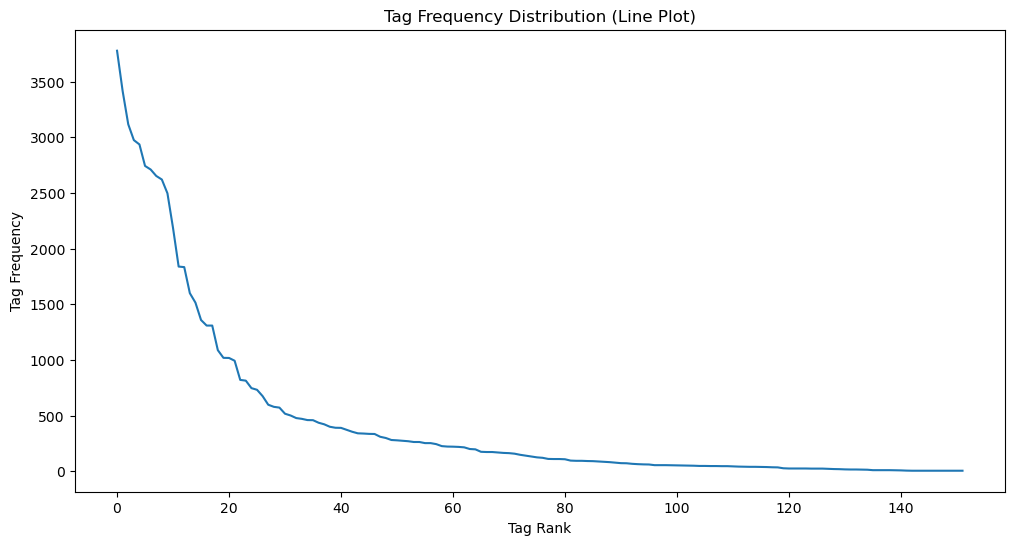

In [184]:
from collections import Counter
import matplotlib.pyplot as plt

#a

#1 Convert to pandas series
all_tags = []
for tag_list in combined_df_renamed['property_tags']:
    if isinstance(tag_list, list):
        all_tags.extend(tag_list)

# Count the frequency of each tag
tag_counts = Counter(all_tags)

tag_counts_series = pd.Series(tag_counts).sort_values(ascending=False)

# Select the value from the X amount from the data.
minCount = int(tag_counts_series.values[80]) # the value of tag with the rank 15 will be taken

print("Min Count/ Threshold", minCount) # see the value to prevent making mistakes.

# Plot code for visualization
plt.figure(figsize=(12,6))
plt.plot(tag_counts_series.values)
plt.xlabel("Tag Rank")
plt.ylabel("Tag Frequency")
plt.title("Tag Frequency Distribution (Line Plot)")
plt.show()

In [189]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    """
    - Splits data into train and test sets.
    - Applies target encoding to 'city', 'state', and 'county'.
    - Applies one-hot encoding to 'property_tags' (with a frequency threshold).
    - Returns cleaned train and test sets.
    """

    # 1️⃣ Train-Test Split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # 2️⃣ Target Encoding (City, State, County)
    target_cols = ['city', 'state', 'county']
    overall_mean = train_df['sold_price'].mean()

    for col in target_cols:
        mapping = train_df.groupby(col)['sold_price'].mean()
        train_df[col] = train_df[col].map(mapping)
        test_df[col] = test_df[col].map(mapping).fillna(overall_mean)

    # 3️⃣ One-Hot Encoding for Property Tags
    if 'property_tags' in df.columns:
        # Flatten the list of all tags
        all_tags = train_df['property_tags'].explode()
        tag_counts = all_tags.value_counts()

        # Keep tags that appear at least 50 times
        frequent_tags = tag_counts[tag_counts >= 50].index.tolist()

        def encode_tags(tag_list):
            if not isinstance(tag_list, list):  # Handle None or unexpected types
                tag_list = []
            return pd.Series({tag: 1 if tag in tag_list else 0 for tag in frequent_tags})

        # Apply to train and test
        train_tags = train_df['property_tags'].apply(encode_tags)
        test_tags = test_df['property_tags'].apply(encode_tags)

        # Drop original property_tags column
        train_df = train_df.drop(columns=['property_tags']).join(train_tags)
        test_df = test_df.drop(columns=['property_tags']).join(test_tags)

    return train_df, test_df




In [191]:
# Example usage:
train_df1, test_df1 = preprocess_data(combined_df_renamed)
train_df1.shape, test_df1.shape

((5372, 127), (1344, 127))

In [195]:
display(train_df1.head())
display("====================================")
display(test_df1.head())

,listing_source,full_address,listing_status,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,baths_half,...,gated_community,cathedral_ceiling,community_spa_or_hot_tub,senior_community,big_bathroom,elevator,mountain_view,rv_parking,marina,smart_homes
2793,mls,50-Annabelle-Ave_Trenton_NJ_08610_M59114-26490,sold,2023-12-29 00:00:00,1930,0,2023-12-29,275000,1,0,...,0,0,0,0,0,0,0,0,0,0
1457,mls,29-Pierce-St_Boston_MA_02136_M46283-22309,sold,2024-01-12 00:00:00,1920,0,2024-01-12,825000,3,0,...,0,0,0,0,0,0,0,0,0,0
7202,mls,87-Moreland-St_Roxbury_MA_02119_M39610-78758,sold,2024-01-12 00:00:00,1900,0,2024-01-12,891000,3,0,...,0,0,0,0,0,0,0,0,0,0
7004,mls,3401-Rogers-Dr_Edmond_OK_73013_M82379-77490,sold,2024-01-12 00:00:00,1992,0,2024-01-12,510000,3,1,...,0,0,0,0,0,0,0,0,0,0
4506,mls,2404-S-9th-St_Springfield_IL_62703_M86149-63827,sold,2023-08-17 00:00:00,1920,0,2023-11-10,42000,2,0,...,0,0,0,0,0,0,0,0,0,0


'===================================='

,listing_source,full_address,listing_status,list_date,year_built,baths_3qtr,sold_date,sold_price,baths_full,baths_half,...,gated_community,cathedral_ceiling,community_spa_or_hot_tub,senior_community,big_bathroom,elevator,mountain_view,rv_parking,marina,smart_homes
7142,mls,131-Sundew-Rd_Elgin_SC_29045_M96784-01203,sold,2023-09-29 00:00:00,2020,0,2023-08-01,263626,2,0,...,0,0,0,0,0,0,0,0,0,0
5083,mls,4305-Central-Ave_Harrisburg_PA_17112_M41730-13199,sold,2024-01-10 00:00:00,1951,0,2024-01-03,225000,1,0,...,0,0,0,0,0,0,0,0,0,0
3059,mls,6071-Boylston-Dr_Atlanta_GA_30328_M96882-34273,sold,2024-01-09 00:00:00,2019,0,2024-01-09,710000,3,1,...,0,0,0,0,0,0,0,0,0,0
1924,mls,8956-Old-Charlotte-Pike_Pegram_TN_37143_M75395...,sold,2023-07-21 00:00:00,1983,0,2023-07-21,475000,2,0,...,0,0,0,0,0,0,0,0,0,0
4995,mls,4670-Wagon-Wheel-Rd_Carson-City_NV_89703_M1172...,sold,2023-12-29 00:00:00,1972,0,2023-12-15,350000,2,0,...,0,0,0,0,0,0,0,0,0,0


## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [ ]:
# import, join and preprocess new data here

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [206]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np



numerical_features = ['year_built', 'lot_sqft', 'sqft', 'baths_total', 'garage_spaces', 'num_stories', 'beds', 'sold_price', 'price_reduction']

# Convert numerical features to float64
for col in numerical_features:
    combined_df_renamed[col] = combined_df_renamed[col].astype('float64')



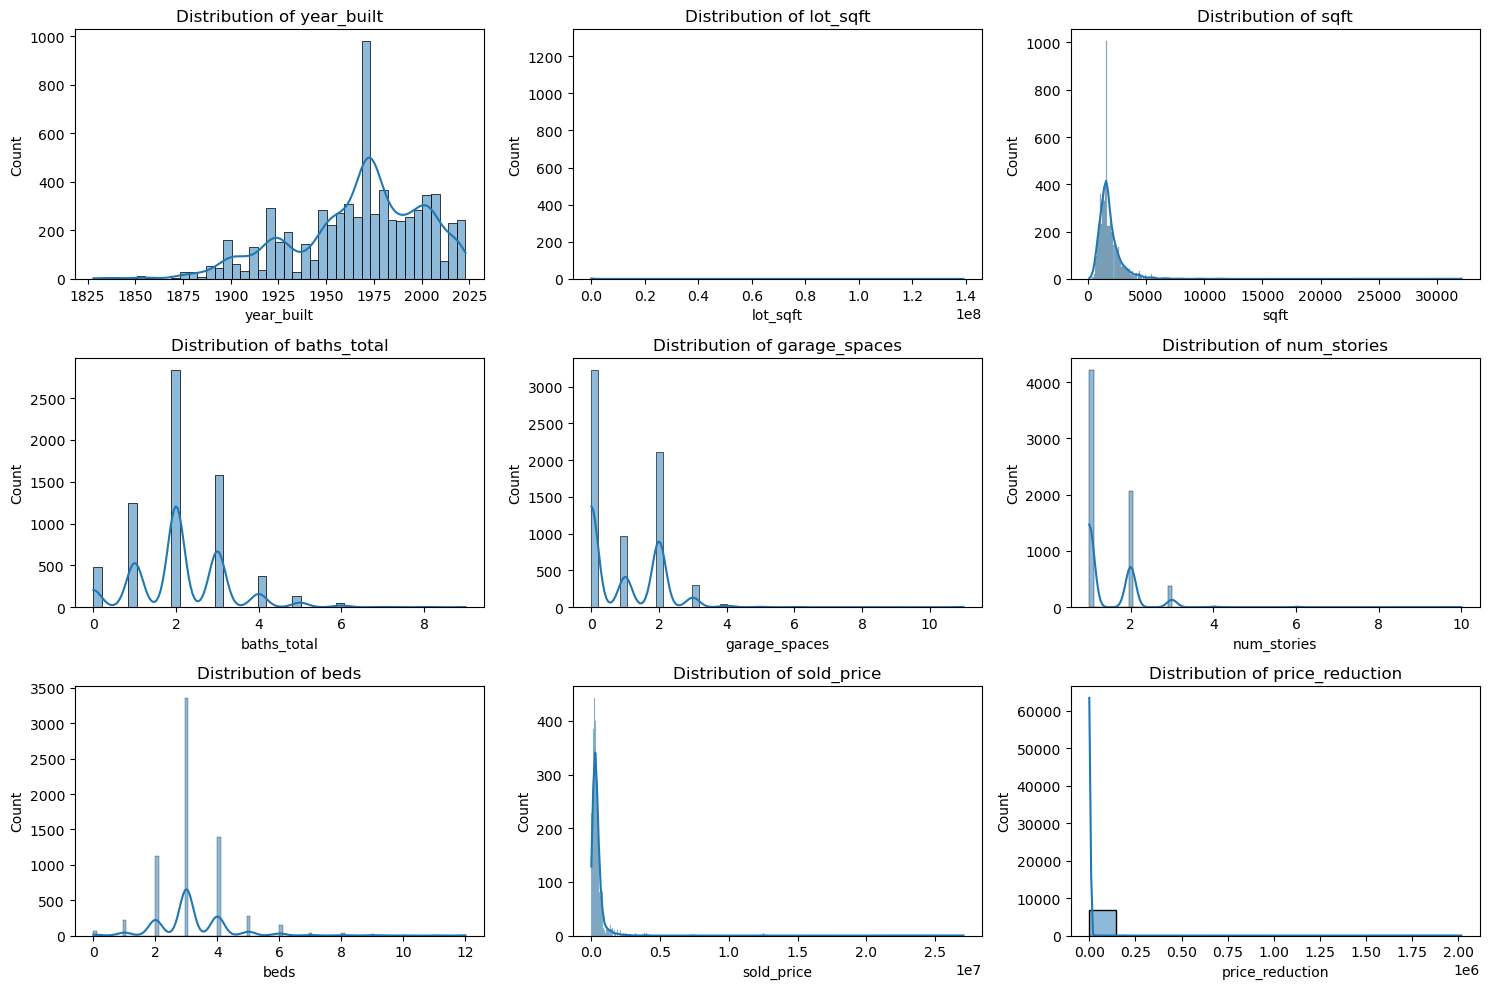

In [207]:
# 1. Distribution of Numerical Variables
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(combined_df_renamed[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

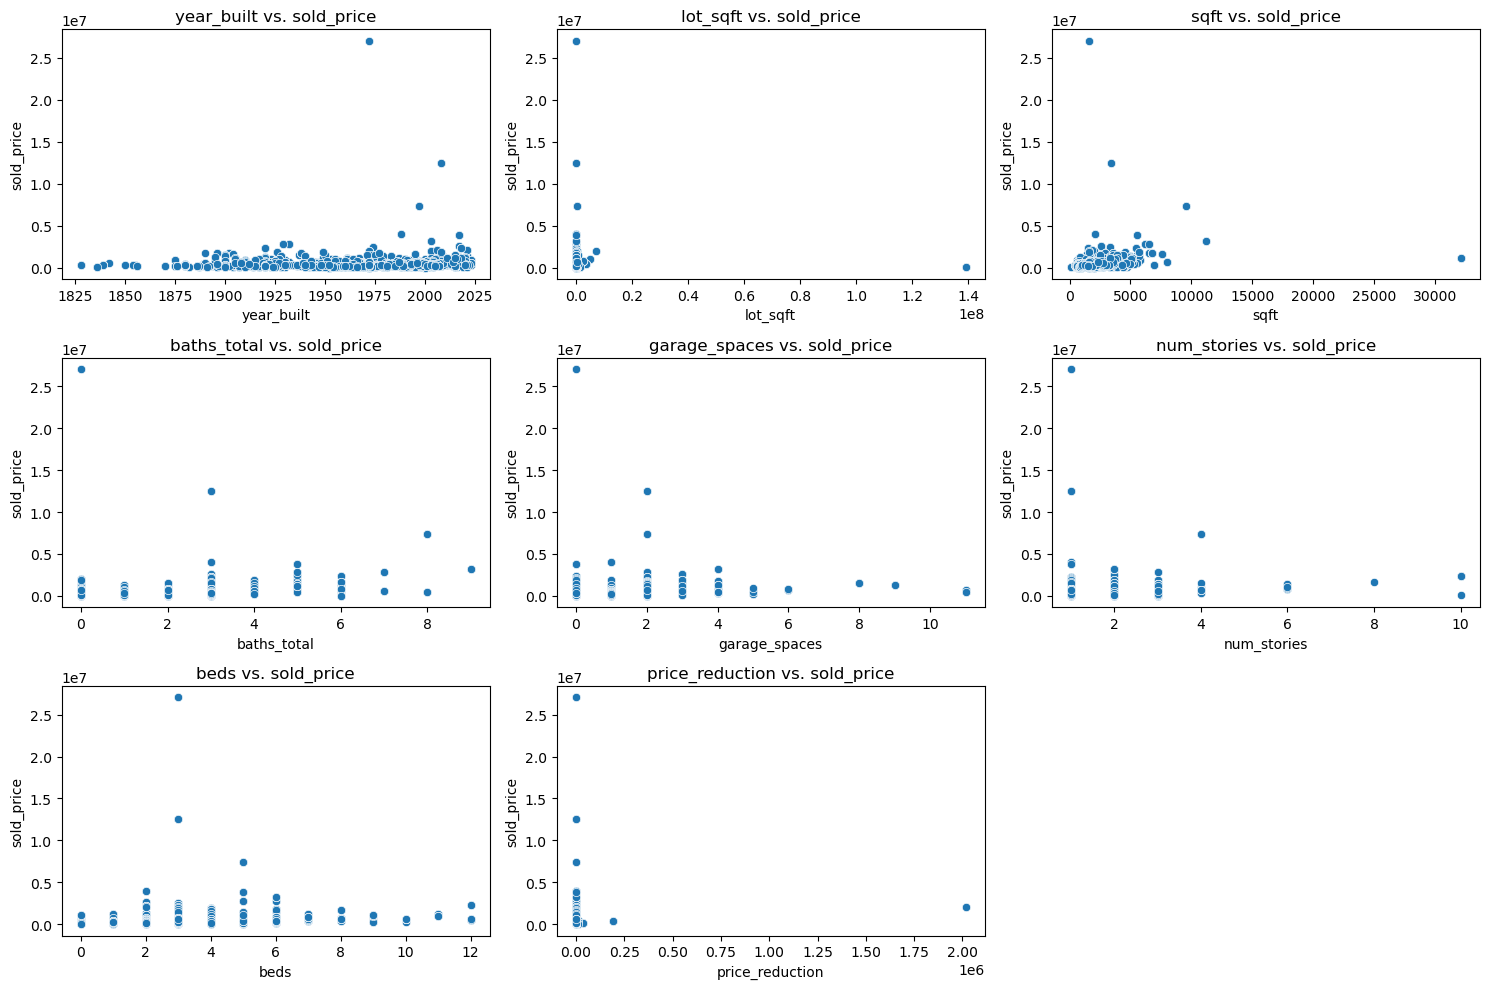

In [208]:
# 2. Scatter Plots (Numerical vs. Target)
numerical_features_for_scatter = ['year_built', 'lot_sqft', 'sqft', 'baths_total', 'garage_spaces', 'num_stories', 'beds', 'price_reduction']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features_for_scatter):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=combined_df_renamed[feature].dropna(), y=combined_df_renamed['sold_price'])
    plt.title(f'{feature} vs. sold_price')
plt.tight_layout()
plt.show()

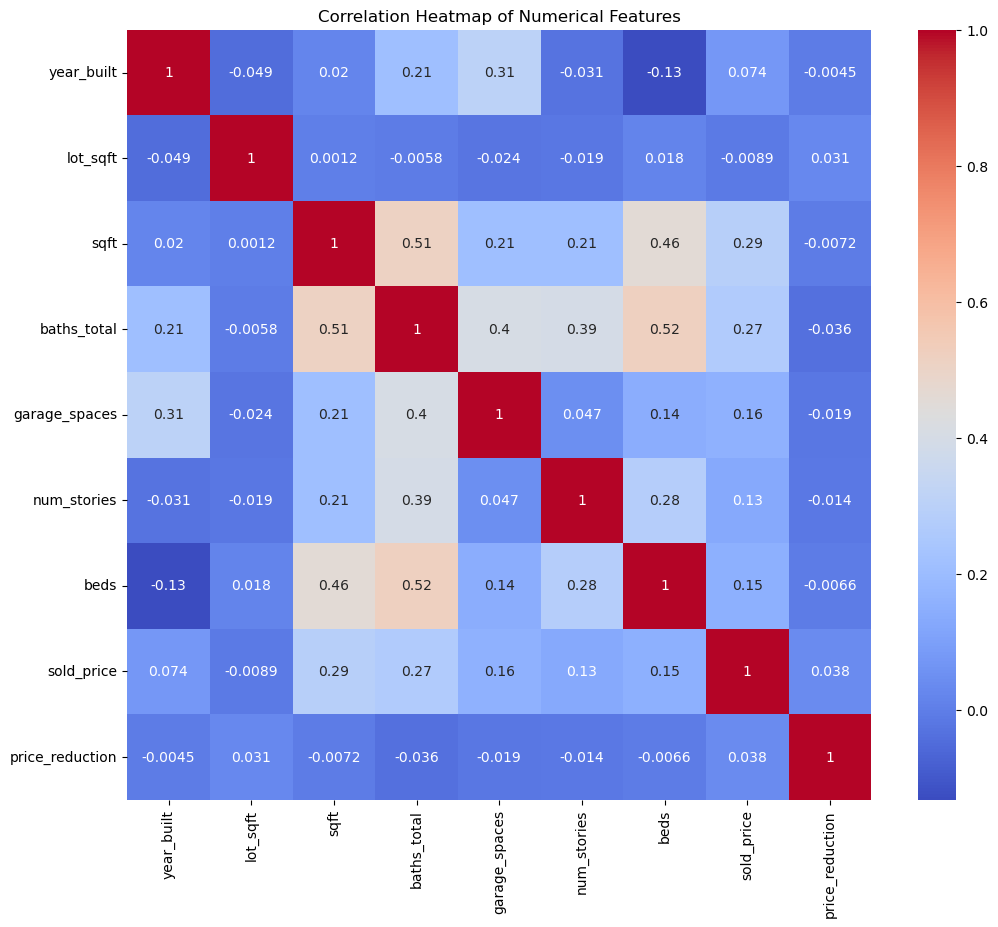

In [209]:
# 3. Heatmap or Correlation Analysis
correlation_matrix = combined_df_renamed[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [210]:
# Calculate skewness for each numerical feature individually
for col in numerical_features:
    try:
        col_skewness = skew(combined_df_renamed[col].dropna())
        print(f"Skewness for column '{col}': {col_skewness}")
    except Exception as e:
        print(f"Error calculating skewness for column '{col}': {e}")

Skewness for column 'year_built': -0.6866613062855204
Skewness for column 'lot_sqft': 36.464624159007705
Skewness for column 'sqft': 11.036193898629119
Skewness for column 'baths_total': 0.7213466523057027
Skewness for column 'garage_spaces': 1.8435776299707836
Skewness for column 'num_stories': 3.0633177731816783
Skewness for column 'beds': 1.9242766840631704
Skewness for column 'sold_price': 21.56843151735897
Skewness for column 'price_reduction': 56.043322816747455


In [211]:
#4. Identifying skewed features
from scipy.stats import skew

# Calculate skewness for each numerical feature in the list
skewed_feats = pd.Series({col: skew(combined_df_renamed[col].dropna()) for col in numerical_features})


skewed_feats = skewed_feats[abs(skewed_feats) > 0.5]
skewed_feats = skewed_feats.sort_values(ascending=False)
print("Skewed features: %s" % skewed_feats)

Skewed features: price_reduction    56.043323
lot_sqft           36.464624
sold_price         21.568432
sqft               11.036194
num_stories         3.063318
beds                1.924277
garage_spaces       1.843578
baths_total         0.721347
year_built         -0.686661
dtype: float64


### Skewness Calculation Observations

### 1. Individual Skewness Calculation:
The following are the skewness values for each numerical feature in the dataset:

- **year_built**: -0.69 (moderately skewed to the left)
- **lot_sqft**: 36.46 (highly positively skewed)
- **sqft**: 11.04 (highly positively skewed)
- **baths_total**: 0.72 (moderately positively skewed)
- **garage_spaces**: 1.84 (moderately positively skewed)
- **num_stories**: 3.06 (highly positively skewed)
- **beds**: 1.92 (moderately positively skewed)
- **sold_price**: 21.57 (highly positively skewed)
- **price_reduction**: 56.04 (highly positively skewed)

### 2. Identifying Highly Skewed Features:
The following features have skewness greater than 0.5 or less than -0.5, indicating they are significantly skewed:

- **price_reduction**: 56.04 (highly positively skewed)
- **lot_sqft**: 36.46 (highly positively skewed)
- **sold_price**: 21.57 (highly positively skewed)
- **sqft**: 11.04 (highly positively skewed)
- **num_stories**: 3.06 (highly positively skewed)
- **beds**: 1.92 (moderately positively skewed)
- **garage_spaces**: 1.84 (moderately positively skewed)
- **baths_total**: 0.72 (moderately positively skewed)
- **year_built**: -0.69 (moderately skewed to the left)

### Conclusion:
- Many features are **positively skewed**, especially those related to property size (e.g., `lot_sqft`, `sqft`) and pricing (`sold_price`, `price_reduction`).
- The high skewness values in the dataset suggest that transformations (e.g., log transformation) may be needed to improve model performance, especially for regression tasks.


## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [205]:
import os
from sklearn.preprocessing import StandardScaler

# Make sure the 'processed' directory exists
processed_folder = '/Users/fitsumbahlebi/Desktop/repo2/LHL-supervised-learning-midterm/data/processed'
os.makedirs(processed_folder, exist_ok=True)

# Extract numerical columns to scale (drop 'sold_price' as it's the target)
numerical_cols = train_df1.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('sold_price')  # We don't want to scale the target variable

# Initialize the scaler
scaler = StandardScaler()

# Scale training and testing data
train_scaled = train_df1[numerical_cols].copy()
test_scaled = test_df1[numerical_cols].copy()

# Fit and transform the training data, then transform the test data
train_scaled[numerical_cols] = scaler.fit_transform(train_scaled[numerical_cols])
test_scaled[numerical_cols] = scaler.transform(test_scaled[numerical_cols])


# Concatenate all columns at once instead of inserting individually
train_scaled = pd.concat([train_scaled, train_df1[['sold_price']]], axis=1)
test_scaled = pd.concat([test_scaled, test_df1[['sold_price']]], axis=1)

# Save the scaled data to CSV files
train_scaled.to_csv(os.path.join(processed_folder, 'train_scaled.csv'), index=False)
test_scaled.to_csv(os.path.join(processed_folder, 'test_scaled.csv'), index=False)

print("Data scaling and saving completed!")


Data scaling and saving completed!
